In [1]:
import torch
import json
import torch.nn as nn
import datetime
import torch.nn.functional as F
from env_parallel import Env
from ppo import Agent
import torch.nn.init as init
import numpy as np

In [2]:
class PolicyValueModel(nn.Module):
    def __init__(self, count_of_actions, n):
        super(PolicyValueModel, self).__init__()

        # self.conv1 = nn.Conv1d(1, 16, 3)
        # self.conv2 = nn.Conv1d(16, 32, 3)

        self.fc_p1 = nn.Linear(count_of_actions * 2, n)
        self.fc_p2 = nn.Linear(n, count_of_actions)

        self.fc_v1 = nn.Linear(count_of_actions * 2, n)
        self.fc_v2 = nn.Linear(n, 1)

        features_layers = []  # [self.conv1, self.conv2]
        for layer in features_layers:
            torch.nn.init.xavier_normal_(layer.weight)
            torch.nn.init.zeros_(layer.bias)

        output_layers = [self.fc_p1, self.fc_p2, self.fc_v1, self.fc_v2]
        for layer in output_layers:
            torch.nn.init.xavier_normal_(layer.weight)
            torch.nn.init.zeros_(layer.bias)

    def forward(self, x):
        # x = self.conv1(x)
        # x = self.conv2(x)

        # x = x.view(-1, 32)

        x_logit = F.relu(self.fc_p1(x))
        logit = self.fc_p2(x_logit)

        x_value = F.relu(self.fc_v1(x))
        value = self.fc_v2(x_value)

        return logit, value


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)
start_date = datetime.datetime.now()

env_candidates = 664
env_p = 66
env_count = 50
results_path = 'results/'
run_count = 1

dataset_results = json.load(open('data/results.json'))

for i in range(run_count):
    env = Env(env_p, env_candidates, env_count, f'data/{dataset_results[str(env_candidates)]["short"]}-{env_candidates}', device)

    net = PolicyValueModel(env_candidates, 16)
    # net = torch.load('models/save.net')

    agent = Agent(net, device=device, lr=0.01, name=f'p_med_{i}', results_path=results_path, epsilon = 0.2, td_steps=env_p, lr_decay=0.5)

    agent.train(env=env, count_of_envs=env_count, input_dim=(env_candidates * 2,), count_of_iterations=200, count_of_steps=3 * env_p, batch_size=3 * env_p)

# agent.test(env)

print(datetime.datetime.now() - start_date)


device:  cuda
optimizer: Adam
Training is starting
iteration:        0 	epsiode:  50 	score:  -0.6835 	avg score:  -0.6824 	Best score:  -0.5304 Obj:  68353 	Avg obj:   68235 	Best obj: 53044.0
iteration:        0 	epsiode:  100 	score:  -0.6603 	avg score:  -0.6770 	Best score:  -0.5246 Obj:  66032 	Avg obj:   67695 	Best obj: 52456.0
iteration:        0 	epsiode:  150 	score:  -0.6092 	avg score:  -0.6681 	Best score:  -0.5048 Obj:  60924 	Avg obj:   66811 	Best obj: 50479.0
iteration:        1 	epsiode:  200 	score:  -0.7072 	avg score:  -0.6604 	Best score:  -0.5048 Obj:  70721 	Avg obj:   66040 	Best obj: 50479.0
iteration:        1 	epsiode:  250 	score:  -0.6064 	avg score:  -0.6634 	Best score:  -0.5048 Obj:  60642 	Avg obj:   66338 	Best obj: 50479.0
iteration:        1 	epsiode:  300 	score:  -0.7588 	avg score:  -0.6731 	Best score:  -0.5048 Obj:  75879 	Avg obj:   67309 	Best obj: 50479.0
iteration:        2 	epsiode:  350 	score:  -0.6016 	avg score:  -0.6686 	Best score: 

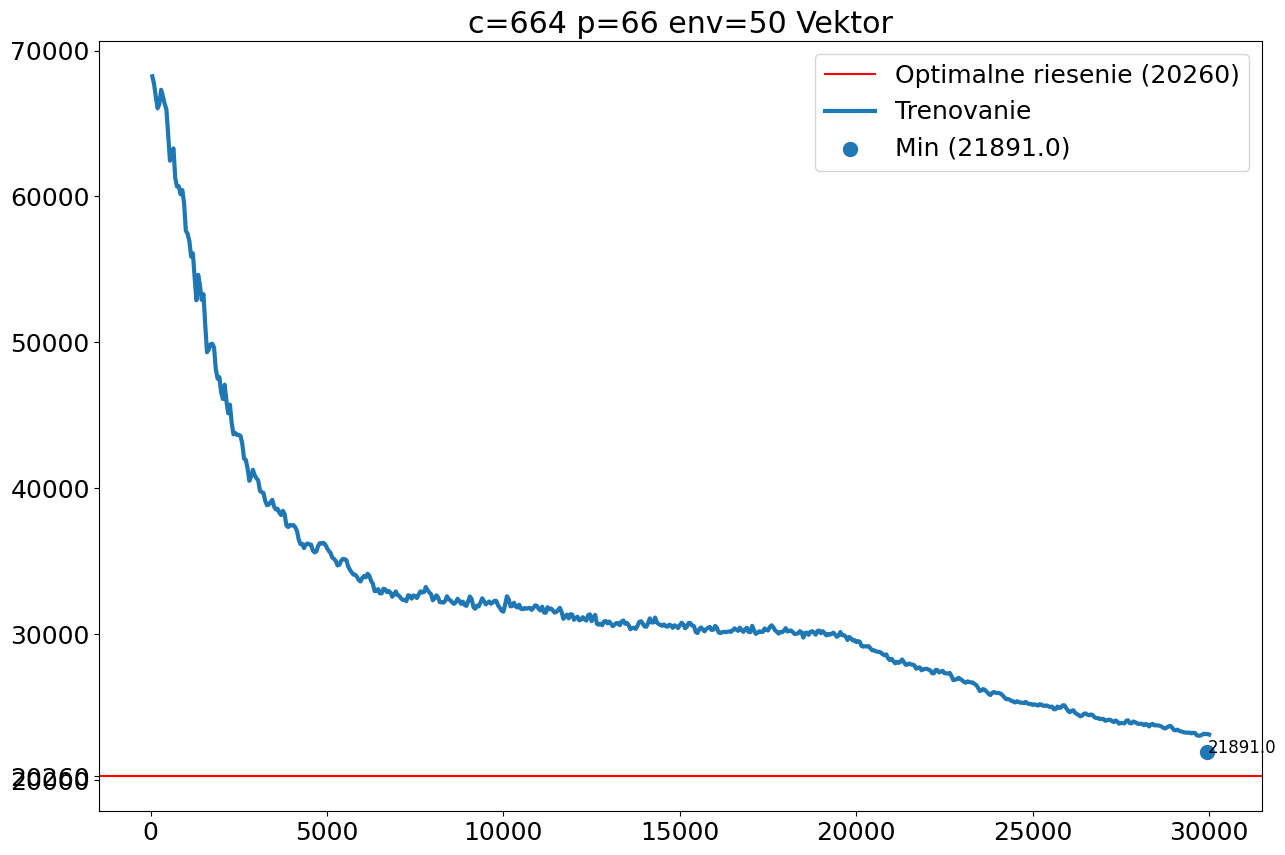

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
rcParams.update({'font.size': 18})

dataset_results = json.load(open('data/results.json'))

optimalne = dataset_results[str(env_candidates)][str(env_p)]
plt.title(f'c={env_candidates} p={env_p} env={env_count} Vektor')
plt.axhline(y=optimalne, color='r', label=f'Optimalne riesenie ({optimalne})')
for i in range(run_count):
    data = pd.read_csv(f'results/p_med_{i}.csv')
    d = data['avg_obj']
    plt.plot(data['episode'], d, linewidth=3, label=f'Trenovanie')

    plt.yticks(list(plt.yticks()[0]) + [optimalne])
    
    obj = json.load(open(f'results/p_med_{i}_result.json'))

    plt.scatter(obj['episode'], obj['best_obj'], linewidths=5, label=f'Min ({obj["best_obj"]})')
    plt.annotate(obj['best_obj'], (obj['episode'], obj['best_obj']), fontsize=12)

plt.legend()